# Offline RL (80 Points)

> Name: Seyed Farbod Moosavi

> SID: 402023004




In this notebook, we will implement the Soft Actor Critic (SAC) algorithm on the CartPole environment in both online and offline settings. The SAC framework focuses on maximizing the expected reward while also maximizing entropy, meaning the actor aims to succeed at the task while maintaining a high level of randomness in its actions. This approach explicitly encourages exploration by seeking a high entropy in the policy.

In the second part, we will use the policy learned in the first part to collect a dataset of expert trajectories and perform behavioral cloning.

*The existing results are the baseline for the quality of your implementation.*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio
from tqdm import tqdm


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## Network Structure (10 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [3]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO
        # Define your network layers
        ##########################################################
        self.layer1 = torch.nn.Linear(input_dimension, 128)
        self.layer2 = torch.nn.Linear(128, output_dimension)
        self.output_activation = output_activation

    def forward(self, inpt):
        output = None
        ##########################################################
        # TODO
        # Calculate the output
        ##########################################################
        x = F.relu(self.layer1(inpt))
        output = self.output_activation(self.layer2(x))
        return output

## Replay Buffer

A SAC agent requires a replay buffer to sample previously visited states. You can utilize the implemented code below to set up this replay buffer.

In [4]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 1e-2
        self.delta = 1e-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [5]:
class SACAgent:
    def __init__(self, environment, replay_buffer=None, offline=False, learning_rate=3e-4, discount=0.99, buffer_batch_size=100, alpha_init=1, interpolation_factor=0.01):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.alpha_init = alpha_init
        self.learning_rate = learning_rate
        self.discount = discount
        self.buffer_batch_size = buffer_batch_size
        self.interpolation_factor = interpolation_factor

        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.offline = offline

        ##########################################################
        # TODO
        # Define critics usig your implemented feed forward netwrok
        ##########################################################
        self.critic_local = Network(self.state_dim, self.action_dim)
        self.critic_local2 = Network(self.state_dim, self.action_dim)
        self.critic_optimiser = optim.Adam(self.critic_local.parameters(), lr=self.learning_rate)
        self.critic_optimiser2 = optim.Adam(self.critic_local2.parameters(), lr=self.learning_rate)
        self.critic_target = Network(self.state_dim, self.action_dim)
        self.critic_target2 = Network(self.state_dim, self.action_dim)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        # TODO
        # Define the actor
        # Define the actor optimizer
        ##########################################################
        self.actor_local = Network(self.state_dim , self.action_dim, nn.Softmax(dim=1))
        self.actor_optimiser  = optim.Adam(self.actor_local.parameters(), lr=self.learning_rate)
        ##########################################################
        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.alpha_init), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.learning_rate)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO
        # You are going to calculate critic losses in this method
        ##########################################################
        with torch.no_grad():
            next_action_probs, next_log_probs = self.get_action_info(next_states_tensor)
            min_target_q = self.predict_q_values(next_states_tensor, next_action_probs)
            target_q_value = (next_action_probs * (min_target_q - self.alpha * next_log_probs)).sum(-1).unsqueeze(-1)
            target_value = rewards_tensor.reshape(-1, 1) + (1 - done_tensor.reshape(-1, 1).float()) * self.discount * target_q_value
                    
        current_q1 = self.critic_local(states_tensor).gather(1, actions_tensor.reshape(-1, 1).long())
        current_q2 = self.critic_local2(states_tensor).gather(1, actions_tensor.reshape(-1, 1).long())
        
        critic_loss = F.mse_loss(current_q1, target_value)
        critic2_loss = F.mse_loss(current_q2, target_value)

        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor, actions_tensor):
        ##########################################################
        # TODO
        # Implement the actor loss
        ##########################################################
        action_probs, log_action_probabilities = self.get_action_info(states_tensor)
        min_q = self.predict_q_values(states_tensor, actions_tensor)
        actor_loss = (action_probs * (self.alpha * log_action_probabilities - min_q)).sum(dim=-1).mean()

        return actor_loss, log_action_probabilities
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO
        # Set all the gradients stored in the optimizers to zero
        # Add the new transition to the replay buffer for online case
        ##########################################################
        if self.offline == False:
            self.replay_buffer.add_transition(transition)
            
        if self.replay_buffer.get_size() >= self.buffer_batch_size:
            minibatch = self.replay_buffer.sample_minibatch(self.buffer_batch_size, batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2]))
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            ##########################################################
            # TODO
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it
            # You also need to update \alpha
            ##########################################################
            critic_loss, critic2_loss = self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)

            self.critic_optimiser.zero_grad()
            critic_loss.backward()
            self.critic_optimiser.step()
            
            self.critic_optimiser2.zero_grad()
            critic2_loss.backward()
            self.critic_optimiser2.step()
            
            actor_loss, log_action_probabilities = self.actor_loss(states_tensor, actions_tensor)
            self.actor_optimiser.zero_grad()
            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probabilities)
            self.alpha_optimiser.zero_grad()
            alpha_loss.backward(retain_graph=True)
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp().item()

            self.soft_update_target_networks(self.interpolation_factor)

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities.detach()  + self.target_entropy)).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state, action):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

In [22]:
eval_rewards = np.zeros((4,125))

100%|██████████| 500/500 [10:54<00:00,  1.31s/it]


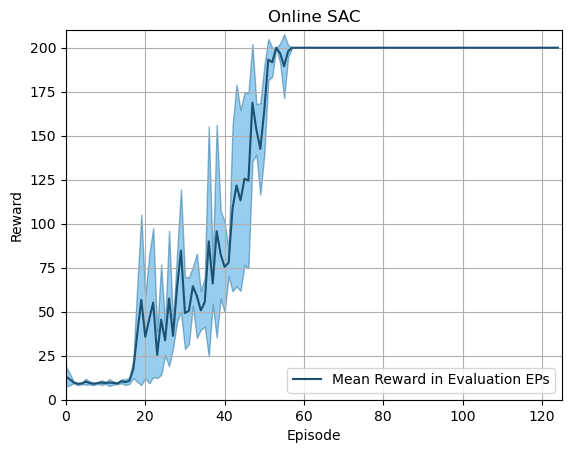

In [27]:
TRAINING_EVALUATION_RATIO = 4
EPISODES_PER_RUN = 500
STEPS_PER_EPISODE = 200
env = gym.make("CartPole-v1")
##########################################################
# TODO
# Implement the training loop for the online SAC.
# After each epoch, run validation
# and plot the mean return over these
# episodes in the end
# Plot the learning curves
##########################################################


eval_rewards = np.zeros((4,125))
# Training Loop
for i in range(4):
    agent = SACAgent(env)
    for episode in tqdm(range(EPISODES_PER_RUN)):
        state, info = env.reset()
        for step in range(STEPS_PER_EPISODE):
            action = agent.get_next_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.train_on_transition(state, action, next_state, reward, terminated)
            state = next_state
            if terminated:
                break
        
        # Eval Loop
        if episode % TRAINING_EVALUATION_RATIO == 0:
            total_reward_eval = 0
            state, info = env.reset()
            for step in range(STEPS_PER_EPISODE):
                action = agent.get_next_action(state, evaluation_episode=True)
                next_state, reward, terminated, truncated, _ = env.step(action)
                state = next_state
                total_reward_eval += reward
                if terminated:
                    break
            eval_rewards[i][int(episode/4)] = total_reward_eval


eval_rewards_mean = np.mean(eval_rewards, axis=0)
eval_rewards_std = np.std(eval_rewards, axis=0)
plt.plot(eval_rewards_mean, color='#1a5273',label='Mean Reward in Evaluation EPs')
plt.fill_between(range(len(eval_rewards_mean)), eval_rewards_mean-eval_rewards_std, eval_rewards_mean+eval_rewards_std,
    alpha=0.5, edgecolor='#226e9c', facecolor='#319dde')
plt.grid(visible=None, which='major', axis='both')
plt.xlim([0,len(eval_rewards_mean)])
plt.ylim([0,210])
plt.title('Online SAC')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()   

In [7]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state, info = env.reset()
for _ in range(100):
    frames.append(env.render())
    action = agent.get_action_deterministically(state) # TODO
    state, reward, done, _, _ = env.step(action)
    if done:
        break

env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Offline SAC (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

Episode 1: Mean Evaluation Reward = 9.75
Episode 41: Mean Evaluation Reward = 19.25
Episode 81: Mean Evaluation Reward = 48.75
Episode 121: Mean Evaluation Reward = 67.5
Episode 161: Mean Evaluation Reward = 120.5
Episode 201: Mean Evaluation Reward = 178.25
Episode 241: Mean Evaluation Reward = 200.0
Episode 281: Mean Evaluation Reward = 200.0
Episode 321: Mean Evaluation Reward = 200.0
Episode 361: Mean Evaluation Reward = 200.0


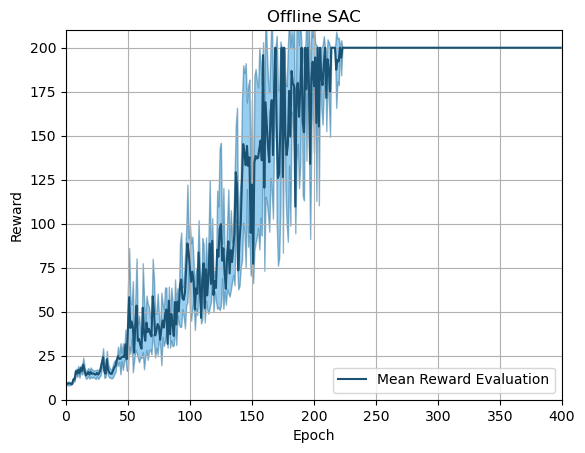

In [21]:
NUM_EPOCHS = 200
EPISODES_PER_RUN = 400

env = gym.make("CartPole-v1")

##########################################################
# TODO
# Implement the training loop for the offline SAC.
# After each epoch, run  validation
# and plot the mean return over these
# episodes in the end
##########################################################

agent_offline = SACAgent(env, replay_buffer=agent.replay_buffer, offline=True)
eval_rewards_mean = []
eval_rewards_std = []
# Training Loop
for episode in range(EPISODES_PER_RUN):
    for epoch in range(NUM_EPOCHS):
        agent_offline.train_networks()
    # Eval Loop
    total_reward_eval = [0, 0, 0, 0]
    for i in range(4):
        state, info = env.reset()
        for step in range(STEPS_PER_EPISODE):
            action = agent_offline.get_next_action(state, evaluation_episode=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            total_reward_eval[i] += reward
            if terminated:
                break
    if episode % 40 == 0:
            print(f"\rEpisode {episode + 1}: Mean Evaluation Reward = {np.mean(total_reward_eval)}")
    eval_rewards_mean.append(np.mean(total_reward_eval))
    eval_rewards_std.append(np.std(total_reward_eval))


plt.plot(np.array(eval_rewards_mean), color='#1a5273',label='Mean Reward Evaluation')
plt.fill_between(range(len(eval_rewards_mean)), np.array(eval_rewards_mean)-np.array(eval_rewards_std), np.array(eval_rewards_mean)+np.array(eval_rewards_std),
    alpha=0.5, edgecolor='#226e9c', facecolor='#319dde')
plt.grid(visible=None, which='major', axis='both')
plt.xlim([0,len(eval_rewards_mean)])
plt.ylim([0,210])
plt.title('Offline SAC')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.legend()
plt.show() 

In [28]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state, info = env.reset()
for _ in range(100):
    frames.append(env.render())
    action = agent_offline.get_action_deterministically(state) # TODO
    state, reward, done, _, _ = env.step(action)
    if done:
        break

env.close()
imageio.mimsave('./online.mp4', frames, fps=25)
show_video('./online.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


 # Behavioural Cloning (20 points)

Behavioral cloning works by mimicking expert behavior through supervised learning. It involves collecting a dataset of expert trajectories, which are sequences of state-action pairs (unlike offline reinforcement learning, which also collects rewards to train the model). The model is then trained to predict the expert's actions based on the observed states. The goal is for the model to replicate the expert's behavior by minimizing the difference between its predicted actions and the expert's actions.

We first need to collect data using the previously trained model.

In [14]:
env = gym.make('CartPole-v1')
num_episodes = 1000
expert_data = []

# TODO
# Collect state-action pairs
bc_buffer = ReplayBuffer(env, capacity=500000)
for episode in tqdm(range(num_episodes)):
    state, info = env.reset()
    for step in range(STEPS_PER_EPISODE):
        action = agent.get_action_deterministically(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        transition = (state, action, reward, next_state, done)
        state = next_state
        bc_buffer.add_transition(transition)
        if terminated:
            break

100%|██████████| 1000/1000 [00:20<00:00, 48.68it/s]


Define the model for behavioural cloning.

In [15]:
class BCModel(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        super(BCModel, self).__init__()
        # TODO
        # Define the model
        self.fc1 = nn.Linear(input_dimension, hidden_dimension)
        self.fc2 = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        # TODO
        # Perform forward pass
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return output

In this section, we implement the training loop for behavioral cloning. During each iteration, we sample a minibatch of state-action pairs from the expert dataset. This minibatch is then used to update the model.

In [16]:
bc_model = BCModel(env.observation_space.shape[0], 128, env.action_space.n)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bc_model.parameters(), lr=3e-4)

num_epochs = 5
batch_size = 64


for epoch in range(num_epochs):
    total_loss = 0
    # TODO
    # Implement behavioural cloning training loop
    batch_pointer = 0
    for i in tqdm(range(0, bc_buffer.get_size(), batch_size)):
        batch_pointer += batch_size
        minibatch = bc_buffer.sample_minibatch(size=batch_size, batch_deterministic_start=batch_pointer)
        minibatch_separated = list(map(list, zip(*minibatch)))
        states_tensor = torch.tensor(np.array(minibatch_separated[0]))
        actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
        action_pred = bc_model(states_tensor)
        loss = criterion(action_pred, actions_tensor.long())
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')

100%|██████████| 3125/3125 [00:49<00:00, 62.73it/s]


Epoch 1/5, Loss: 681.7467828467488


100%|██████████| 3125/3125 [00:48<00:00, 64.71it/s]


Epoch 2/5, Loss: 440.72311281599104


100%|██████████| 3125/3125 [00:47<00:00, 65.35it/s]


Epoch 3/5, Loss: 393.04495014436543


100%|██████████| 3125/3125 [00:47<00:00, 65.15it/s]


Epoch 4/5, Loss: 359.44390764832497


100%|██████████| 3125/3125 [00:48<00:00, 64.93it/s]

Epoch 5/5, Loss: 329.2270036712289


Evaluate and render the results.

In [19]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

state, info = env.reset()
for _ in range(100):
    frames.append(env.render())
    state = torch.tensor(state).unsqueeze(0)
    action = bc_model(state).argmax().item() # TODO
    state, reward, done, _, _ = env.step(action)
    if done:
        break
env.close()
imageio.mimsave('./bc.mp4', frames, fps=25)
show_video('./bc.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
